<a href="https://colab.research.google.com/github/krakowiakpawel9/computer-vision-course/blob/master/10_tensorflow_hub/02_classification-transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning z użyciem Tensorflow Hub

Tensorflow Hub: [tfhub.dev](https://tfhub.dev/)

Tensorflow Hub to biblioteka pozwalająca na wielokrotne i darmowe wykorzystywanie modułów modeli uczenia maszynowego. Tzw. transfer learning pozwala nam skorzystać z wcześniej wyuczonych modeli uczenia maszynowego na bardzo dużych zbiorach danych z zaawansowaną architekturą. Pozwala to zdecydowanie zaoszczędzic sporo czasu na dewelopowaniu własnych modeli, czy chociażby na mocy obliczeniowej wykorzystywaniej podczas trenowania. 

Przykłady użycia transfer learningu:
 - trenowanie modelu z małym zbiorem danych
 - pozwala poprawić generalizację modeli
 - przyśpiesza proces trenowania modeli
 - niski próg wejścia dla osób chcących poznać zastosowania modeli

 ### Spis treści:
1. [Import bibliotek](#a1)
2. [Załadowanie modelu](#a2)
3. [Załadowanie etykiet](#a3)
4. [Załadowanie obrazu](#a4)
5. [Predykcja na podstawie modelu](#a5)
6. [Wyświetlenie predykcji](#a6)
7. [Transfer Learning](#a7)







### <a name='a1'></a>Import bibliotek

In [19]:
%tensorflow_version 2.x
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
print(f'Tensorflow version: {tf.__version__}')
print(f'Tensorflow Hub version: {hub.__version__}')

Tensorflow version: 2.0.0
Tensorflow Hub version: 0.7.0


### <a name='a2'></a> Załadowanie modelu

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### <a name='a3'></a> Załadowanie etykiet

In [3]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

16384/10484 [==============================================] - 0s 0us/step


array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

### <a name='a4'></a> Załadowanie obrazu

In [4]:
from google.colab import files
uploaded = files.upload()

Saving office.jpg to office.jpg


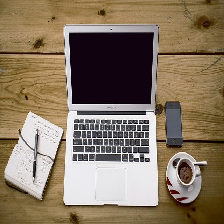

In [5]:
filename = list(uploaded.keys())[0]
img = Image.open(filename).resize(IMAGE_SHAPE)
img

### <a name='a5'></a> Predykcja na podstawie modelu

In [6]:
img_arr = np.array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)
result = classifier.predict(img_arr)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class_name = imagenet_labels[predicted_class]
predicted_class_name

'notebook'

### <a name='a6'></a> Wyświetlenie predykcji

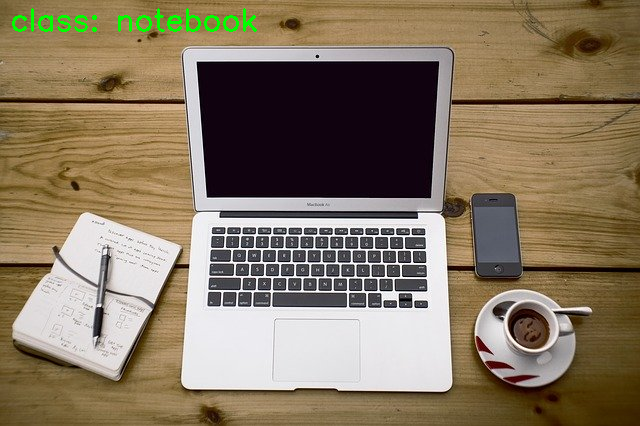

In [7]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread(filename)
text = f'class: {predicted_class_name}'
img = cv2.putText(img=img, text=text, org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2)
cv2_imshow(img)

###  <a name='a7'></a> Transfer Learning

In [0]:
%%bash
wget -q https://storage.googleapis.com/esmartdata-courses-files/opencv-python/images.zip
unzip -q images.zip

In [9]:
# budowa generatora 
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory('images', target_size=IMAGE_SHAPE)

# pobranie wsadu danych
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

# predykcja
result_batch = classifier.predict(image_batch)

# wyświetlenie klas
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

Found 1113 images belonging to 2 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


array(['lion', 'sorrel', 'Great Dane', 'sorrel', 'lion', 'sorrel', 'lion',
       'muzzle', 'lion', 'book jacket', 'gazelle', 'breastplate',
       'warthog', 'lion', 'lion', 'bison', 'horse cart', 'chain mail',
       'lion', 'horse cart', 'mask', 'white wolf', 'horse cart',
       'horse cart', 'Ibizan hound', 'muzzle', 'sorrel', 'French bulldog',
       'sorrel', 'lion', 'lion', 'whippet'], dtype='<U30')

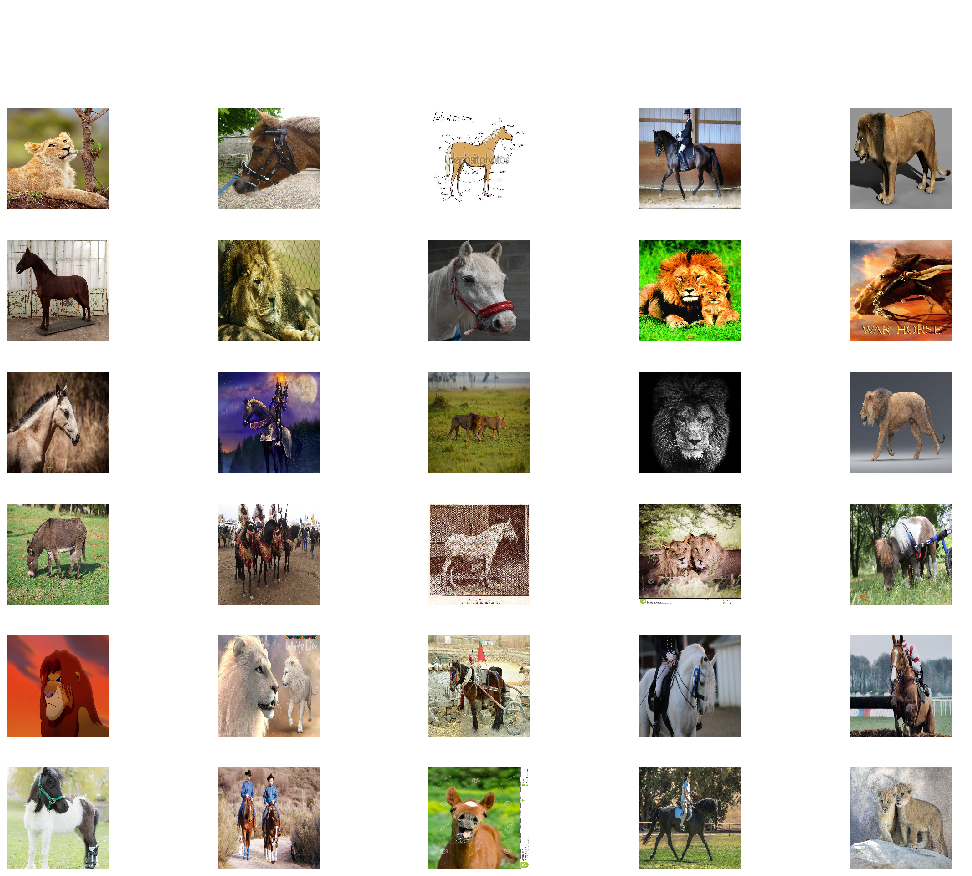

In [29]:
plt.figure(figsize=(18, 14))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n], color='white', fontdict={'fontsize': 20})
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions", color='white', fontsize=20)

Wykorzystamy teraz tzw. ekstraktor cech (model bez ostatniej warstwy klasyfikacyjnej). Pozwala to na łatwe użycie poprzez dołączenie swojej ostatniej warstwy.

In [13]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_url,
    input_shape=IMAGE_SHAPE+(3,)
)

# zamrażamy wagi ekstraktora
feature_extractor_layer.trainable = False

# budujemy model dokładając ostatnią warstwę klasyfikacji
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# zbudujemy niestandardowy Callback aby rejestrować stratę (loss) i dokładność (accuracy) po każdym wsadzie (batch)
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [15]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=1,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

 1/35 [..............................] - ETA: 9:09 - loss: 0.6807 - acc: 0.5625

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


35/35 [==============================] - 229s 7s/step - loss: 0.2697 - acc: 1.0000


In [20]:
def plot_hist(batch_stats_callback):
    hist = pd.DataFrame({'loss': batch_stats_callback.batch_losses,
                         'accuracy': batch_stats_callback.batch_acc})
    hist['batch'] = hist.index
    hist['batch'] += 1  

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['batch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.update_layout(width=800, height=400, title='accuracy', xaxis_title='batches', yaxis_title='accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['batch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.update_layout(width=800, height=400, title='loss', xaxis_title='batches', yaxis_title='loss', yaxis_type='log')
    fig.show()

plot_hist(batch_stats_callback)

In [21]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Horse', 'Lion'], dtype='<U5')

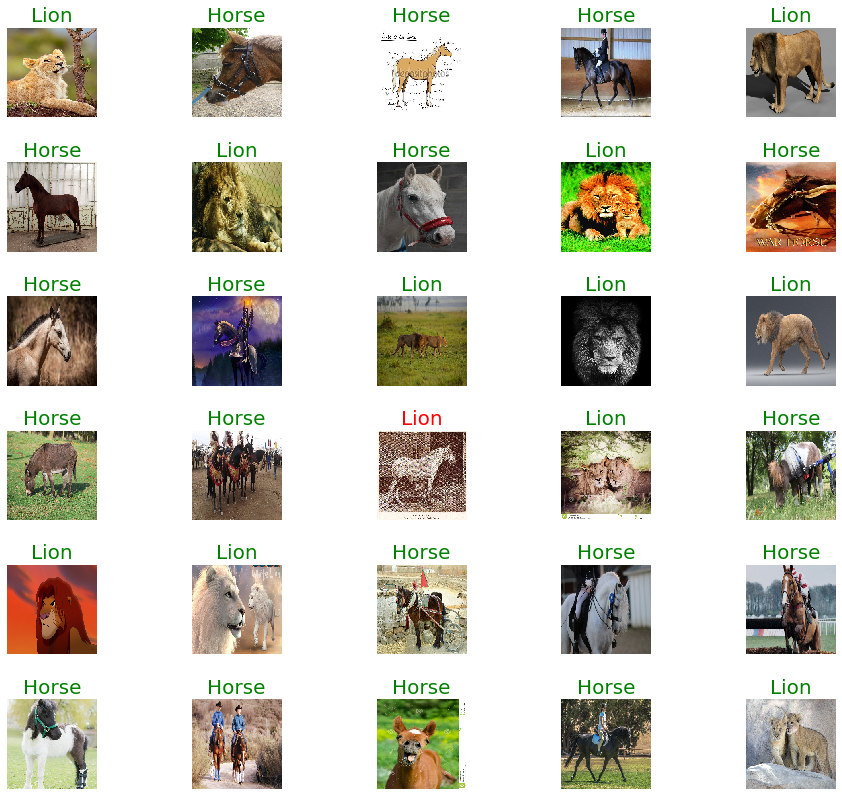

In [27]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(16, 14))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color, fontdict={'fontsize': 20})
    plt.axis('off')

In [0]:
model.save('models/model_name', save_format='tf')